In [1]:
import numpy as np
from scipy.optimize import minimize,fsolve
import math
import matplotlib.pyplot as plt
from MLE import *
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Estimacion de Máxima Verosimilitud 

### Distribución Normal

Los [datos](https://seattlecentral.edu/qelp/sets/059/059.html) provienen de un experimento de Mercer and Hall sobre el rendimiento fanegas de trigo por unidad de tierra  Rothamsted Experimental Station en Gran Bretaña. Los datos siguen una distribución normal, por lo que buscamos obtener los estimadores de máxima verosmilitud. 




In [2]:
global data
data=np.loadtxt('wheat_yield.txt')


Al graficar el hsitograma de frecuencias se observa que la distribución tiene forma de una normal.

Text(0.5, 0, 'Fanegas de trigo por unidad de tierra')

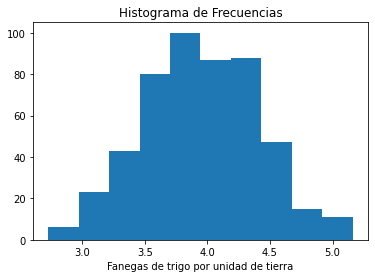

In [3]:
plt.hist(data)
plt.title('Histograma de Frecuencias')
plt.xlabel('Fanegas de trigo por unidad de tierra')

La función de log-verosimilitud asociada a una ditribución normal. Debido a que se plantea un problema de minimización, el resultado es multiplicado por -1.

In [4]:
def normal_loglikelihood(params,*args):
    mu = params[0]
    sigma = params[1]
    x = data
    n=len(data)
    
    loglikelihood=-(n/2)*np.log(2*np.pi)-(n/2)*np.log(sigma**2)-(1/(2*sigma**2))*np.sum((x-mu)**2)
    
    return -1*loglikelihood


In [5]:
x1_grid=np.linspace(2,6,1000)
x2_grid=np.linspace(.1,1.5,1000)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
positions = np.vstack([X1.ravel(), X2.ravel()]).T
ll_eval=np.array([np.log(normal_loglikelihood(i,data)) for i in positions])

In [6]:
ll_eval=ll_eval.reshape(1000,1000)

Text(0, 0.5, 'sigma')

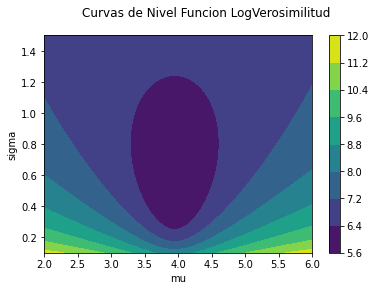

In [7]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X1, X2, ll_eval)
fig.colorbar(cp) 
fig.suptitle('Curvas de Nivel Funcion LogVerosimilitud')
ax.set_xlabel('mu')
ax.set_ylabel('sigma')

En la grafica anterior, se realiza un ajuste des escala aplicando una transformacion logarítmica a la función de log-verosimilitud. Esta es una transformación monótona por lo que la ubicación del punto máximo no se ve afectado. 

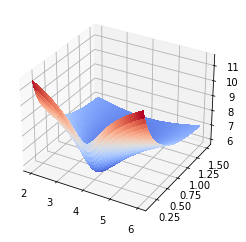

In [8]:

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, ll_eval, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

Para poder calcular el mínimo del negativo de la función logverosimilitud, calcularmos el gradiente que nos dictará la dirección de descenso. 

In [19]:
def gradient_normal_loglike(params,*args):
    mu = params[0]
    sigma = params[1]
    x=data
    n=len(data)
    dmu= (1/(sigma**2))*np.sum(x-mu)
    dsigma=-(n/2)*((2*sigma)/sigma**2)+(1/sigma**3)*np.sum((x-mu)**2)
    return -1*np.array([dmu,dsigma])


El el algoritmo descenso en gradiente toma una paso en el negativo de la dirección del gradiente. El tamaño de paso está ajustado por con coeficiente, en este caso .0001. Existen 2 criterios de paro, un máximo número de iteraciones y diferencia entre la estimación de la iteración $k+1$ y $k$.

In [44]:
x=np.array([1,1])
def gradient_descent(x,gradient,tol=.0001,maxiter=10000,step_size=.0001):
    x_old=x+10
    i=0
    points=list()
    while ((np.linalg.norm(x-x_old)>=tol)):
        if i==1000:
            break
        points.append(x)
        x_old=x
        x=x-step_size*gradient(x)
        i+=1
    return x

In [45]:
x=gradient_descent(x,gradient_normal_loglike)

Se grafica la trayectoria de descenso hasta llegar al mínimo de la función. 

Text(0, 0.5, 'sigma')

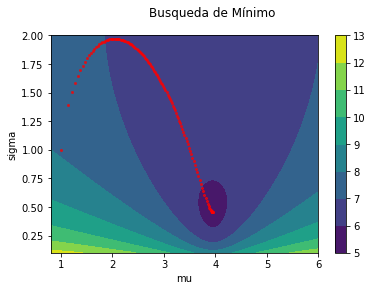

In [46]:
x1_grid=np.linspace(.8,6,1000)
x2_grid=np.linspace(.1,2,1000)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
positions = np.vstack([X1.ravel(), X2.ravel()]).T
ll_eval=np.array([np.log(normal_loglikelihood(i,data)) for i in positions])
ll_eval=ll_eval.reshape(1000,1000)


fig,ax=plt.subplots(1,1)
cp = ax.contourf(X1, X2, ll_eval)



for i in points:
    ax.plot(i[0],i[1], linestyle='--', marker='o', color='red',alpha=.7,markersize=2)
fig.colorbar(cp) 
fig.suptitle('Busqueda de Mínimo')
ax.set_xlabel('mu')
ax.set_ylabel('sigma')


Para contrastar los resultados obtenidos por el algoritmo de descenso en gradiente, se programa la solución analítica al problema y se evalúa con el mismo conjunto de datos.

In [39]:
mean_analytic_normal=lambda x: sum(x)/len(x)

def std_analytic_normal(data, ddof=0):
     n = len(data)
     mean = sum(data) / n
     return np.sqrt(sum((x - mean) ** 2 for x in data) / (n - ddof))

In [40]:
estimators=x
print(estimators)

[3.9458489  0.45789091]


In [41]:
print(mean_analytic_normal(data))
print(std_analytic_normal(data))

3.9486399999999997
0.45782108994671694


El error relativo del estimador de máxima verosimilitud para la media es de: 

In [42]:
(estimators[0]-mean_analytic_normal(data))/abs(mean_analytic_normal(data))

-0.000706850571584146

El error relativo del estimador de máxima verosimilitud para la desviación estandar es de: 

In [50]:
(estimators[1]-std_analytic_normal(data))/abs(std_analytic_normal(data))

0.000152504490583337